In [1]:
# Imports
import pathlib

import numpy as np
import torch
from skimage.io import imread
from skimage.transform import resize

from inference import predict
from transformations import normalize_01, re_normalize
from unet import UNet

# root directory
root = pathlib.Path.cwd() / "Carvana" / "Test"


def get_filenames_of_path(path: pathlib.Path, ext: str = "*"):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames


# input and target files
images_names = get_filenames_of_path(root / "Input")
targets_names = get_filenames_of_path(root / "Target")

# read images and store them in memory
images = [imread(img_name) for img_name in images_names]
targets = [imread(tar_name) for tar_name in targets_names]

# Resize images and targets
images_res = [resize(img, (128, 128, 3)) for img in images]
resize_kwargs = {"order": 0, "anti_aliasing": False, "preserve_range": True}
targets_res = [resize(tar, (128, 128), **resize_kwargs) for tar in targets]

/home/kalyan/anaconda3/envs/deepl/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# model
model = UNet(
    in_channels=3,
    out_channels=2,
    n_blocks=4,
    start_filters=32,
    activation="relu",
    normalization="batch",
    conv_mode="same",
    dim=2,
).to(device)


model_name = "carvana_model.pt"
model_weights = torch.load(pathlib.Path.cwd() / model_name, map_location=device)

model.load_state_dict(model_weights)


<All keys matched successfully>

In [3]:
# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img


# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img)  # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img


In [4]:
# predict the segmentation maps
output = [predict(img, model, preprocess, postprocess, device) for img in images_res]


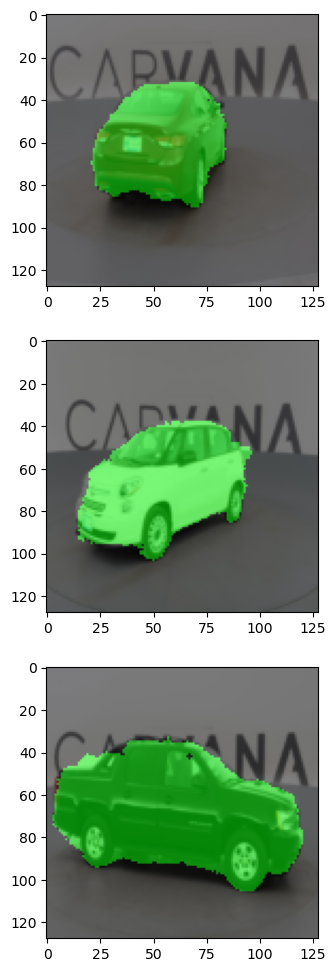

In [17]:
from skimage import color
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 12))
for n, (pred, img) in enumerate(zip(output, images_res)):
    #print(img)
    green_multiplier = [0, 1, 0]
    pred_img = color.gray2rgb(pred)
    pred_img = green_multiplier * pred_img/255.0
    ax = plt.subplot(3, 1, n + 1)
    plt.imshow((pred_img*0.5 + img * 0.5))